In [1]:
'''
Yeast colony simulation combining cellular automata and numerical diffusion scheme. 
'''

'\nYeast colony simulation combining cellular automata and numerical diffusion scheme. \n'

In [2]:
%matplotlib inline
from scipy import signal
from __future__ import print_function
import numpy as np
import sys 
import random
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt 
# from tqdm import tqdm 
matplotlib.rcParams['figure.figsize'] = [12, 9]

In [3]:
#Yeast Cell Class. This is treated as a group of cells at a location

class yeast_cell:
    def __init__(self, live=1, gen=0, leaf=0,location=(0,0), gluconD=0,plate=1,id=1):
        self.location=location #coordinates (x,y)
        self.gluconD=gluconD #dark/light state of the cell group.
        self.FoodReserve=0.5 #internal resource levels in the cell group.
        self.Amino = 0.5 #internal amino acid reserve
        self.id=1 #cell group number


In [4]:
# Convolve with Resource grid for a diffusion constant of 0.24
DiffMat = np.array([[0,0.24,0],
                  [0.24,0.04,0.24],
                  [0,0.24,0]])

In [5]:
#Returns the neighbourhood occupancy of an empty location on the grid. 
def FillProb(locn):
    count=0
    cx=locn[0]
    cy=locn[1]
    cell_neigh = [(max(0,cx-1),cy),(cx,min(cy+1,gridleny-1)),(min(cx+1,gridlenx-1),cy),(cx,max(0,cy-1))]
    shuffle(cell_neigh)
    for locn in cell_neigh:
        if locn in LOC_STATE.keys(): 
            count+=1 #if a neighbourhood location is occupied, increase the counter
    return count 

In [6]:
TimeSteps = 100 #Give the system enough time to switch and grow

In [7]:
#MAIN PARAMETER MODELS AND INITIAL CONDITIONS
#size of the grids
gridlenx=251
gridleny=251


food=1.0 #minimum amount of of resource needed to be able to divide
GlucInit=0.0 #units of glucose available at each grid location at t=0
resource=GlucInit*np.ones(shape=(gridlenx,gridleny)) #resource grid at t=0

DarkThresh = 0.3 # If external resource falls below this, light cells can turn dark
dark_freq = 0.0 #probability to turn dark from light

LightThresh = 3.0 # If external resource is higher than this, dark cells can turn light
light_freq=0.5 #probability to turn light from dark


Produced=0.07 #Resource produced by a dark cell per time step
Consumed = 0.05 #Resource consumed by a light cell per time step (if available)
DarkGrowth = 0.01 #growth rate of dark cells
LightGrowth = 0.04 #growth rate of light cells

In [8]:
#Initial Variables the ones which we tend to keep track of
GLUCON_FRAC=[] #fraction of dark cells in the colony
POPU_TOTAL=[] #total cell population
POPU_NUM=[] #tracks simply number of cells
LOC=[] #all coordinates
COLONY_GRID = np.zeros(shape=(gridlenx,gridleny)) #2D colony grid 
ColonyTime = np.zeros(shape=(TimeSteps+1,gridlenx,gridleny)) #store colony grid states over time
GlucTime = np.zeros(shape=(TimeSteps+1,gridlenx,gridleny)) #store resource grid states over time
LOC_STATE={} #At location (x,y) store the dark/light state of the cell. 

In [9]:
#seed island with cells
GLUCON_COUNTER=0 #gluconeogenic cells
cx=int((len(resource[:-1])-1)/2)
cy=cx 
cell_id=0
island = []
radius = 20
for x in range(gridlenx):
    for y in range(gridlenx):
        if (np.sqrt((cx-x)**2+(cy-y)**2))<=radius:
            island.append((x,y))
# the above loop selects an island of the user set radius to seed our colony

#seeding the colony
for locn in island:
    glucons = random.sample(set(island),int(0.99*len(island))) #choose 99% dark cells
    yseed=yeast_cell()
    yseed.id=cell_id
    cell_id+=1
    yseed.location=(locn[0],locn[1])
    LOC_STATE[locn] = 0 # 0 is light
    ColonyTime[0][locn]=1
    POPU_TOTAL.append(yseed)
    LOC.append(yseed.location)
    
    if locn in glucons:
        yseed.gluconD=1
        LOC_STATE[locn] = 1 # 1 is gluconeogenic
        ColonyTime[0][locn]=2
        GLUCON_COUNTER += 1

POPU_NUM.append(len(POPU_TOTAL))

for time_iters in range(TimeSteps+1): #Number of fixed width time steps
    resource = signal.convolve2d(resource,DiffMat,boundary='symm', mode='same') #implement diffusion on the resource grid
    GlucTime[time_iters] = resource
    ColonyTime[time_iters] = ColonyTime[max(0,time_iters-1)]
    
    nextgen=[] # initialise new generation cells
    for a_cell in POPU_TOTAL: #sweep over the whole colony
        cx=a_cell.location[0]
        cy=a_cell.location[1]
        cell_neigh = [(max(0,cx-1),cy),(cx,min(cy+1,gridleny-1)),(min(cx+1,gridlenx-1),cy),(cx,max(0,cy-1))] # '+' shaped neighbourhood

        #Dark (Gluconeogenic) cell
        if a_cell.gluconD == 1: #check if the cell is dark
            if random.random() <= light_freq and resource[cx,cy] >= LightThresh:
                a_cell.gluconD=0 # turn light
                LOC_STATE[(cx,cy)] = 0 #switch to light state
                ColonyTime[time_iters][(cx,cy)] = 1 
                GLUCON_COUNTER -= 1
 
            else:
                resource[cx,cy]=resource[cx,cy]+Produced #produce resource at location
                a_cell.Amino += Consumed #internalise some amino acids
                if random.random()<=DarkGrowth and a_cell.Amino >= food : #dividing dark cell group
                    empty_spot=[] # find an empty space to divide into
                    SpotScore = [] #To find which empty space is surrounded by more occupied spots
                    for locn in cell_neigh:
                        if locn not in LOC:
                            empty_spot.append(locn)
                            SpotScore.append(FillProb(locn))

                    if len(empty_spot)>0:
                        (newglux,newgluy)=empty_spot[SpotScore.index(max(SpotScore))] #divide in the empty spot with the most occupied neighbourhood
                        newcell=yeast_cell() #new cell with properties follows
                        newcell.Amino = a_cell.Amino/2.0
                        a_cell.Amino = a_cell.Amino/2.0 
                        newcell.id=cell_id
                        newcell.gluconD = 1
                        cell_id+=1
                        nextgen.append(newcell)
                        newcell.location=(newglux,newgluy)
                        LOC.append(newcell.location)
                        LOC_STATE[(newglux,newgluy)] = 1
                        ColonyTime[time_iters][(newglux,newgluy)] = 2
                        GLUCON_COUNTER+=1

        # Light cell
        elif a_cell.gluconD == 0:
            if random.random()<=dark_freq and resource[cx,cy] < DarkThresh:
                a_cell.gluconD=1 #become gluconeogenic if you can
                LOC_STATE[a_cell.location] = 1
                ColonyTime[time_iters][(cx,cy)]=2
                GLUCON_COUNTER+=1
     
            if a_cell.gluconD == 0:
                if resource[cx,cy] >=Consumed: #minimum amount which should be present at the cell group's location
                    resource[cx,cy]=max(0,resource[cx,cy]-Consumed)
                    a_cell.FoodReserve += Consumed #build internal reserve of resource for division
                    
                if a_cell.FoodReserve >= food and random.random() <=LightGrowth:
                    empty_spot=[] # find an empty space to divide into
                    SpotScore=[]
                    for locn in cell_neigh:
                        if locn not in LOC:
                            empty_spot.append(locn)
                            SpotScore.append(FillProb(locn))
                    if len(empty_spot)>0:
                        (newx,newy)=empty_spot[SpotScore.index(max(SpotScore))]
                        newcell=yeast_cell()
                        newcell.id=cell_id
                        cell_id+=1
                        newcell.FoodReserve = a_cell.FoodReserve/2.0
                        nextgen.append(newcell)
                        newcell.location=(newx,newy)
                        LOC_STATE[(newx,newy)] = 0
                        ColonyTime[time_iters][(newx,newy)] = 1
                        LOC.append(newcell.location)
                        a_cell.FoodReserve = a_cell.FoodReserve/2.0

                
    POPU_TOTAL=POPU_TOTAL+nextgen #update population by adding new generation
    POPU_NUM.append(len(POPU_TOTAL))
    GLUCON_FRAC.append(float(GLUCON_COUNTER)/len(POPU_TOTAL))


savefilename = 'Colony.npy'
np.save(savefilename,ColonyTime)

np.save('Resource',GlucTime)


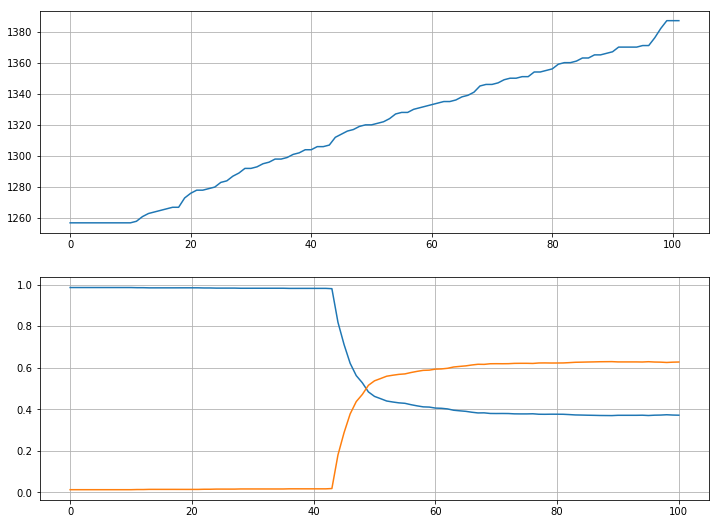

In [10]:
GLYCFRAC = [1.0 - a for a in GLUCON_FRAC ]
plt.figure()
plt.subplot(2,1,1).plot(POPU_NUM) #total population over time
plt.grid(True)
plt.subplot(2,1,2).plot(GLUCON_FRAC) #dark cell fraction
plt.subplot(2,1,2).plot(GLYCFRAC) #light cell fraction
plt.grid(True)